In [2]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import snntorch as snn
from snntorch import spikegen, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

# image transformations
transform = transforms.Compose([
    transforms.Resize((28, 28)),  
    transforms.ToTensor(),         
    transforms.Normalize((0.5,), (0.5,)) 
])

# load datasets - train, test, validation
train_dataset = torchvision.datasets.ImageFolder(root='./data/stft_plots_org/train', transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root='./data/stft_plots_org/test', transform=transform)
val_dataset = torchvision.datasets.ImageFolder(root='./data/stft_plots_org/val', transform=transform)

# data loaders - train, test, validation
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [ ]:
# Define the SNN
class SNN(nn.Module):
    def __init__(self, num_classes=10, num_steps=10):
        super(SNN, self).__init__()

        self.num_steps = num_steps

        # Define the network layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 14 * 14, 128)  # input size
        self.fc2 = nn.Linear(128, num_classes)

        # Initialize LIF neurons
        self.lif1 = snn.Leaky(beta=0.9)
        self.lif2 = snn.Leaky(beta=0.9)
        self.lif3 = snn.Leaky(beta=0.9)

    def forward(self, x):
        spk_rec = []
        utils.reset(self)  # Reset the state of all neurons

        for step in range(self.num_steps):
            x_step = x[step]  # Get the input for the current time step
            x_step = self.conv1(x_step)
            x_step, _ = self.lif1(x_step)

            x_step = self.conv2(x_step)
            x_step, _ = self.lif2(x_step)

            x_step = F.max_pool2d(x_step, 2)
            x_step = x_step.view(x_step.size(0), -1)

            x_step = self.fc1(x_step)
            x_step, _ = self.lif3(x_step)

            x_step = self.fc2(x_step)
            spk_rec.append(x_step)
            # Save spk_rec as pickle file
            # And plot them as individual images
        return torch.stack(spk_rec)

# Initialize the model
num_classes = 10
num_steps = 25
model = SNN(num_classes=num_classes, num_steps=num_steps)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Rate coding
        inputs = spikegen.rate(inputs, num_steps=num_steps)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.sum(dim=0), labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    return running_loss / len(data_loader)

# Testing loop
def test(model, data_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Rate coding
            inputs = spikegen.rate(inputs, num_steps=num_steps)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.sum(dim=0), 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return 100 * correct / total

# Training and testing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")
model.to(device)

train_losses = []
val_accuracies = []
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_acc = test(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

# Final test accuracy
test_acc = test(model, test_loader, criterion, device)
print(f"Test Accuracy: {test_acc:.2f}%")




Training on cuda


/home/arafat/work/thesis/snn/env/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/10, Train Loss: 2.1510, Val Accuracy: 33.67%
Epoch 2/10, Train Loss: 1.5630, Val Accuracy: 60.20%
Epoch 3/10, Train Loss: 1.1986, Val Accuracy: 62.24%
Epoch 4/10, Train Loss: 1.0548, Val Accuracy: 68.37%
Epoch 5/10, Train Loss: 0.8431, Val Accuracy: 73.47%
Epoch 6/10, Train Loss: 0.7079, Val Accuracy: 71.43%
Epoch 7/10, Train Loss: 0.6197, Val Accuracy: 73.47%
Epoch 8/10, Train Loss: 0.5504, Val Accuracy: 73.47%
Epoch 9/10, Train Loss: 0.4191, Val Accuracy: 77.55%
Epoch 10/10, Train Loss: 0.3037, Val Accuracy: 74.49%
Test Accuracy: 73.68%


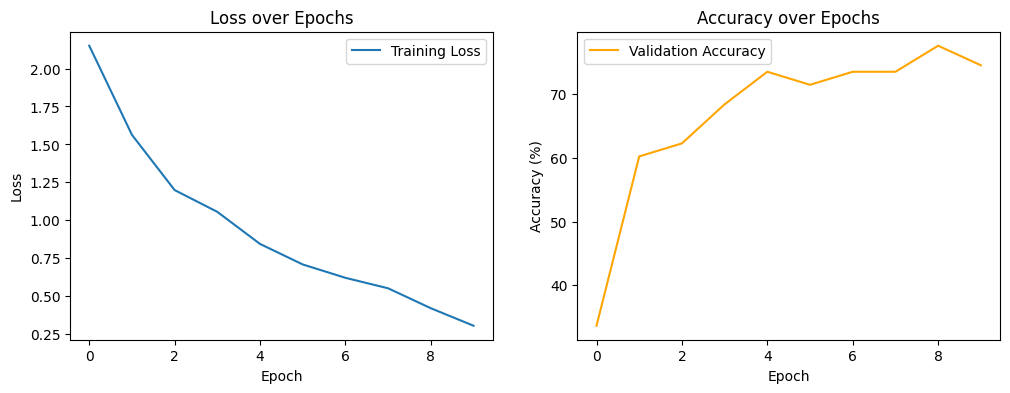

In [4]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()